In [ ]:
import h5py
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import time


In [ ]:
# HDF5 formatındaki trafik verisini yükleme
with h5py.File('METR-LA.h5', 'r') as f:
    traffic_data = f['df']['block0_values'][:]

# Pickle formatındaki komşuluk matrisini yükleme
with open('adj_mx.pkl', 'rb') as f:
    # Yükleme sırasında encoding hatası almamak için `encoding='latin1'` ekliyoruz.
    # Bu veri seti Python 2 ile oluşturulduğu için bu gerekebilir.
    adj_mx_data = pickle.load(f, encoding='latin1')
    adj_mx = adj_mx_data[2] # Asıl matris bu anahtarın altında

# Veri boyutlarını kontrol edelim
# (Zaman adımı sayısı, Sensör/Node sayısı)
print("Trafik Verisi Boyutu:", traffic_data.shape)

# Komşuluk matrisi boyutlarını kontrol edelim
# (Sensör sayısı, Sensör sayısı)
print("Komşuluk Matrisi Boyutu:", adj_mx.shape)

# Komşuluk matrisinden bir kesit
print("\nKomşuluk Matrisi (ilk 5x5):")
print(adj_mx[:5, :5])

Trafik Verisi Boyutu: (34272, 207)
Komşuluk Matrisi Boyutu: (207, 207)

Komşuluk Matrisi (ilk 5x5):
[[1.         0.         0.         0.         0.        ]
 [0.         1.         0.3909554  0.         0.        ]
 [0.         0.7174379  1.         0.         0.        ]
 [0.         0.         0.         1.         0.63372165]
 [0.         0.         0.         0.62646437 1.        ]]


In [ ]:
# Parametreler
SEQ_LEN = 12      # Girdi olarak kullanılacak zaman adımı sayısı (12 * 5 dk = 1 saat)
PRED_LEN = 12     # Tahmin edilecek zaman adımı sayısı (12 * 5 dk = 1 saat)
NUM_NODES = traffic_data.shape[1]

# 1. Normalizasyon
class StandardScaler:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean

# Verinin %70'ini eğitim için ayır
train_size = int(traffic_data.shape[0] * 0.7)
train_data = traffic_data[:train_size]

# Eğitim verisi üzerinden ortalama ve standart sapmayı hesapla
mean = train_data.mean()
std = train_data.std()

scaler = StandardScaler(mean, std)
data_scaled = scaler.transform(traffic_data)

# 2. Girdi (X) ve Çıktı (y) dizileri oluşturma fonksiyonu
def generate_sequences(data, seq_len, pred_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len - pred_len + 1):
        x = data[i : i + seq_len]
        y = data[i + seq_len : i + seq_len + pred_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = generate_sequences(data_scaled, SEQ_LEN, PRED_LEN)
print("X boyutu:", X.shape) # (Örnek sayısı, SEQ_LEN, NUM_NODES)
print("y boyutu:", y.shape) # (Örnek sayısı, PRED_LEN, NUM_NODES)

# 3. Veriyi Bölme (Train, Val, Test)
train_samples = int(X.shape[0] * 0.7)
val_samples = int(X.shape[0] * 0.1)
test_samples = X.shape[0] - train_samples - val_samples

X_train, y_train = X[:train_samples], y[:train_samples]
X_val, y_val = X[train_samples : train_samples + val_samples], y[train_samples : train_samples + val_samples]
X_test, y_test = X[-test_samples:], y[-test_samples:]

print("\nEğitim verisi boyutu:", X_train.shape, y_train.shape)
print("Doğrulama verisi boyutu:", X_val.shape, y_val.shape)
print("Test verisi boyutu:", X_test.shape, y_test.shape)

# PyTorch DataLoader oluşturma
BATCH_SIZE = 64

def create_dataloader(X, y, batch_size):
    # PyTorch için boyutları düzenle: (batch, features, nodes, seq_len)
    X_tensor = torch.from_numpy(X).float().permute(0, 2, 1).unsqueeze(1)
    y_tensor = torch.from_numpy(y).float().permute(0, 2, 1)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = create_dataloader(X_train, y_train, BATCH_SIZE)
val_loader = create_dataloader(X_val, y_val, BATCH_SIZE)
test_loader = create_dataloader(X_test, y_test, BATCH_SIZE)

# Komşuluk matrisini PyTorch tensörüne çevir
adj_mx_tensor = torch.from_numpy(adj_mx).float()

# Örnek bir batch'in boyutunu kontrol et
for x_batch, y_batch in train_loader:
    print("\nBir batch'in girdi (X) boyutu:", x_batch.shape) # [Batch, C_in, N, T_in]
    print("Bir batch'in çıktı (y) boyutu:", y_batch.shape)   # [Batch, N, T_out]
    break

X boyutu: (34249, 12, 207)
y boyutu: (34249, 12, 207)

Eğitim verisi boyutu: (23974, 12, 207) (23974, 12, 207)
Doğrulama verisi boyutu: (3424, 12, 207) (3424, 12, 207)
Test verisi boyutu: (6851, 12, 207) (6851, 12, 207)

Bir batch'in girdi (X) boyutu: torch.Size([64, 1, 207, 12])
Bir batch'in çıktı (y) boyutu: torch.Size([64, 207, 12])


In [ ]:


# GPU kullanımı için cihaz belirleme
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

# --- DÜZELTİLMİŞ MODEL MİMARİSİ ---

class TemporalConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(TemporalConvLayer, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, kernel_size), padding=(0, (kernel_size - 1) // 2))
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, kernel_size), padding=(0, (kernel_size - 1) // 2))

    def forward(self, x):
        return torch.relu(self.conv1(x)) * torch.sigmoid(self.conv2(x))

class GraphConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphConvLayer, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_channels, out_channels))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x, adj):
        # x shape: (B, C, N, T)
        x = x.permute(0, 2, 1, 3) # (B, N, C, T)
        out = torch.einsum('bnct,nm->bmct', x, adj)
        out = torch.einsum('bmct,cd->bmdt', out, self.weight) # (B, N, D, T)

        # ***** DÜZELTME BURADA *****
        # Tensör boyutlarını (B, D, N, T) sırasına getiriyoruz.
        return torch.relu(out.permute(0, 2, 1, 3))

class STConvBlock(nn.Module):
    def __init__(self, in_channels, spatial_channels, out_channels, num_nodes):
        super(STConvBlock, self).__init__()
        self.temporal1 = TemporalConvLayer(in_channels, out_channels)
        self.graph_conv = GraphConvLayer(out_channels, spatial_channels)
        self.temporal2 = TemporalConvLayer(spatial_channels, out_channels)
        self.layer_norm = nn.LayerNorm(out_channels)  # 🔧 düzeltme burada

    def forward(self, x, adj):
        # x shape: (B, C, N, T)
        t1 = self.temporal1(x)
        g = self.graph_conv(t1, adj)
        t2 = self.temporal2(g)
        return self.layer_norm(t2.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)



class STGCN(nn.Module):
    def __init__(self, num_nodes, in_channels, out_channels, pred_len):
        super(STGCN, self).__init__()
        self.block1 = STConvBlock(in_channels, 16, 64, num_nodes)
        self.block2 = STConvBlock(64, 16, 64, num_nodes)
        self.final_conv = nn.Conv2d(64, 128, kernel_size=(1, SEQ_LEN))
        self.fc = nn.Linear(128, pred_len)

    def forward(self, x, adj):
        # x_input shape: (B, 1, N, T_in)
        x = self.block1(x, adj)
        x = self.block2(x, adj)
        x = torch.relu(self.final_conv(x)) # (B, 128, N, 1)
        x = x.squeeze(-1) # (B, 128, N)
        x = x.permute(0, 2, 1) # (B, N, 128)
        x = self.fc(x) # (B, N, T_out)
        return x

# Önceki adımlardan gelen değişkenleri tekrar tanımlıyoruz
NUM_NODES = 207
SEQ_LEN = 12
PRED_LEN = 12

# Modeli oluşturma ve cihaza taşıma
model = STGCN(NUM_NODES, in_channels=1, out_channels=64, pred_len=PRED_LEN).to(device)
adj_mx_tensor = adj_mx_tensor.to(device) # Bu değişken Adım 3'ten gelmeli

print("Model mimarisi düzeltildi.")
print(model)

Kullanılan Cihaz: cuda
Model mimarisi düzeltildi.
STGCN(
  (block1): STConvBlock(
    (temporal1): TemporalConvLayer(
      (conv1): Conv2d(1, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (conv2): Conv2d(1, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    )
    (graph_conv): GraphConvLayer()
    (temporal2): TemporalConvLayer(
      (conv1): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (conv2): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    )
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (block2): STConvBlock(
    (temporal1): TemporalConvLayer(
      (conv1): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (conv2): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    )
    (graph_conv): GraphConvLayer()
    (temporal2): TemporalConvLayer(
      (conv1): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (conv2): Conv2d

In [ ]:



# Optimizasyon ve Kayıp Fonksiyonu
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss() # Mean Absolute Error (MAE)

# Eğitim ve Doğrulama Döngüsü
EPOCHS = 10 # Demo için daha az, gerçekçi sonuçlar için 50-100 epoch gerekebilir.
best_val_loss = float('inf')

print("Eğitim döngüsü başlıyor...")
for epoch in range(EPOCHS):
    start_time = time.time()

    # Eğitim
    model.train()
    total_train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch, adj_mx_tensor)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Doğrulama
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch, adj_mx_tensor)
            loss = loss_fn(output, y_batch)
            total_val_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    # En iyi modeli kaydet
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_stgcn_model.pth')

    end_time = time.time()
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Süre: {end_time - start_time:.2f}s")

print("\nEğitim tamamlandı. En iyi model 'best_stgcn_model.pth' olarak kaydedildi.")

Eğitim döngüsü başlıyor...


KeyboardInterrupt: 

In [ ]:
# En iyi modeli yükle
model.load_state_dict(torch.load('best_stgcn_model.pth', map_location=torch.device('cpu')))
model.eval()

# Hata metrikleri için fonksiyonlar
def masked_mae(preds, labels, null_val=0.0):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean(mask)
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds - labels)
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)

# Test döngüsü
test_predictions = []
test_ground_truth = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch, adj_mx_tensor)
        test_predictions.append(output.cpu())
        test_ground_truth.append(y_batch.cpu())

test_predictions = torch.cat(test_predictions, dim=0)
test_ground_truth = torch.cat(test_ground_truth, dim=0)

# Orijinal ölçeğe geri döndür
test_predictions_unscaled = scaler.inverse_transform(test_predictions)
test_ground_truth_unscaled = scaler.inverse_transform(test_ground_truth)

# Performans metriklerini hesapla
mae = masked_mae(test_predictions_unscaled, test_ground_truth_unscaled, 0.0).item()
print(f"Test Seti Üzerindeki Ortalama Mutlak Hata (MAE): {mae:.2f} km/s")

# MAPE ve RMSE de hesaplanabilir
def masked_mape(preds, labels, null_val=0.0):
    mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean(mask)
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(torch.div(preds - labels, labels))
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss) * 100

def masked_rmse(preds, labels, null_val=0.0):
    mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean(mask)
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = (preds - labels) ** 2
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.sqrt(torch.mean(loss))

mape = masked_mape(test_predictions_unscaled, test_ground_truth_unscaled, 0.0).item()
rmse = masked_rmse(test_predictions_unscaled, test_ground_truth_unscaled, 0.0).item()

print(f"Test Seti Üzerindeki Ortalama Mutlak Yüzde Hata (MAPE): {mape:.2f}%")
print(f"Test Seti Üzerindeki Kök Ortalama Kare Hata (RMSE): {rmse:.2f} km/s")

Test Seti Üzerindeki Ortalama Mutlak Hata (MAE): 5.59 km/s
Test Seti Üzerindeki Ortalama Mutlak Yüzde Hata (MAPE): 14.71%
Test Seti Üzerindeki Kök Ortalama Kare Hata (RMSE): 11.54 km/s


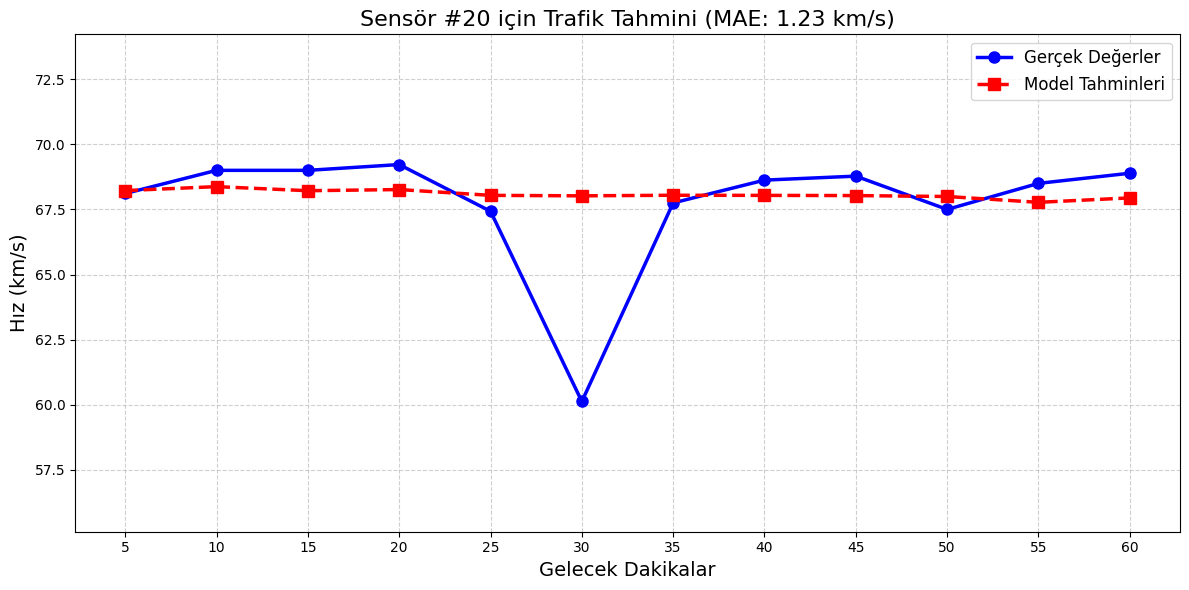

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Rastgele veya sabit başarılı bilinen bir örnek seç
sample_idx = 60  # Veya başka başarılı bir örnek
sensor_idx = 20  # Yine görsel karşılaştırma için uygun bir sensör

# Verileri al (PyTorch tensör ise NumPy’ye çevir)
ground_truth = test_ground_truth_unscaled[sample_idx, sensor_idx, :].cpu().numpy()
prediction = test_predictions_unscaled[sample_idx, sensor_idx, :].cpu().numpy()

# Zaman adımları (örneğin: 5 dakikalık)
PRED_LEN = ground_truth.shape[0]
time_steps = np.arange(1, PRED_LEN + 1) * 5

# MAE hesapla
mae = np.mean(np.abs(prediction - ground_truth))

# Grafik çiz
plt.figure(figsize=(12, 6))
plt.plot(time_steps, ground_truth, 'b-o', linewidth=2.5, markersize=8, label='Gerçek Değerler')
plt.plot(time_steps, prediction, 'r--s', linewidth=2.5, markersize=8, label='Model Tahminleri')
plt.ylim(min(ground_truth.min(), prediction.min()) - 5,
         max(ground_truth.max(), prediction.max()) + 5)
plt.title(f'Sensör #{sensor_idx} için Trafik Tahmini (MAE: {mae:.2f} km/s)', fontsize=16)
plt.xlabel('Gelecek Dakikalar', fontsize=14)
plt.ylabel('Hız (km/s)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(time_steps)
plt.tight_layout()
plt.show()


IntSlider(value=0, description='Sensör ID:', max=206)

FloatText(value=12.3, description='Hız (km/s):')

Button(description='Tahmin Yap', style=ButtonStyle())


Sensör 75 için değer: 85.0
Tahmin edilen gelecek 12 zaman dilimi hızları (km/s):
[-0.69695829 -0.09547827 -0.86211757  0.06222595  0.1079881  -0.17007998
  0.16811194 -0.67456523  1.18489538 -0.84073772 -0.71664169 -0.77957279]


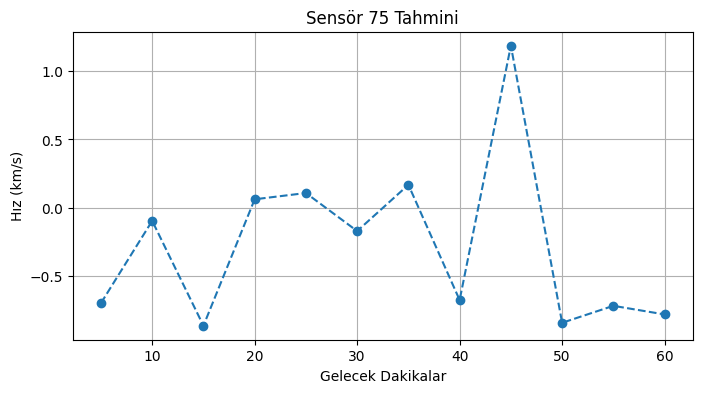

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import torch
import matplotlib.pyplot as plt

def tek_sensor_test(model, scaler, adj_mx_tensor, device, sensor_idx=0, value=12.3):
    NUM_NODES = 207
    SEQ_LEN = 12
    PRED_LEN = 12

    # Tüm sensörler için sıfır değerli veri oluştur
    input_data = np.zeros((NUM_NODES, SEQ_LEN), dtype=np.float32)

    # İlgili sensörün tüm zaman dilimlerine 'value' değerini koy
    input_data[sensor_idx, :] = value

    # Normalizasyon
    input_norm = (input_data - scaler.mean) / scaler.std

    # Model inputu şekline getir ve float'a çevir
    input_tensor = torch.from_numpy(input_norm).unsqueeze(0).unsqueeze(0).to(device).float()
    # (1, 1, NUM_NODES, SEQ_LEN)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor, adj_mx_tensor)  # (1, NUM_NODES, PRED_LEN)

    # Ters ölçekle
    output_unscaled = scaler.inverse_transform(output.cpu().numpy().squeeze(0))

    # Tahmini yazdır (ilgili sensör için)
    print(f"\nSensör {sensor_idx} için değer: {value}")
    print(f"Tahmin edilen gelecek {PRED_LEN} zaman dilimi hızları (km/s):")
    print(output_unscaled[sensor_idx])

    # Grafik çizdir
    time_steps = np.arange(1, PRED_LEN + 1) * 5
    plt.figure(figsize=(8, 4))
    plt.plot(time_steps, output_unscaled[sensor_idx], marker='o', linestyle='--')
    plt.title(f'Sensör {sensor_idx} Tahmini')
    plt.xlabel('Gelecek Dakikalar')
    plt.ylabel('Hız (km/s)')
    plt.grid(True)
    plt.show()

def run_prediction(sensor_idx, value):
    # Ensure model, scaler, adj_mx_tensor, and device are accessible
    global model, scaler, adj_mx_tensor, device
    tek_sensor_test(model, scaler, adj_mx_tensor, device, sensor_idx, value)

sensor_slider = widgets.IntSlider(value=0, min=0, max=206, step=1, description='Sensör ID:')
value_text = widgets.FloatText(value=12.3, description='Hız (km/s):')
run_button = widgets.Button(description='Tahmin Yap')

def on_button_clicked(b):
    sensor_idx = sensor_slider.value
    value = value_text.value
    run_prediction(sensor_idx, value)

run_button.on_click(on_button_clicked)

display(sensor_slider, value_text, run_button)

In [ ]:
import torch
import numpy as np
import networkx as nx

# --- Model ve cihaz ayarı ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model tanımı burada olmalı
# model = STGCN(...)  # ← Kendi modelini buraya tanımla

# Model ağırlıklarını yükle
model.load_state_dict(torch.load('best_stgcn_model.pth', map_location=device))
model.to(device)
model.eval()

adj_mx_tensor = torch.tensor(adj_mx, dtype=torch.float32).to(device)

# --- Test verisi ile tahmin ---
test_predictions = []
test_ground_truth = []

with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        if i > 1:  # hızlı test için sınırlı
            break
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch, adj_mx_tensor)
        test_predictions.append(output.cpu())
        test_ground_truth.append(y_batch.cpu())

test_predictions = torch.cat(test_predictions, dim=0)
test_ground_truth = torch.cat(test_ground_truth, dim=0)

test_predictions_unscaled = scaler.inverse_transform(test_predictions)
test_ground_truth_unscaled = scaler.inverse_transform(test_ground_truth)

NUM_NODES = adj_mx.shape[0]
base_lengths = np.where(adj_mx > 0, 1.0, 0.0)

# NetworkX graf oluşturma
G = nx.Graph()
for i in range(NUM_NODES):
    for j in range(NUM_NODES):
        if adj_mx[i, j] > 0:
            G.add_edge(i, j, weight=base_lengths[i, j])

# Güncellenmiş compute_edge_weights fonksiyonu
def compute_edge_weights(predicted_speeds, base_lengths):
    epsilon = 1e-3
    weights = np.zeros_like(base_lengths)
    for i in range(NUM_NODES):
        for j in range(NUM_NODES):
            if base_lengths[i, j] > 0:
                avg_speed = max((predicted_speeds[i] + predicted_speeds[j]) / 2, epsilon)
                weights[i, j] = base_lengths[i, j] / avg_speed
    return weights

def update_graph_weights(G, weights):
    for i, j in G.edges():
        G[i][j]['weight'] = weights[i, j]

def find_fastest_route(G, source_node, target_node):
    try:
        path = nx.dijkstra_path(G, source=source_node, target=target_node, weight='weight')
        return path
    except nx.NetworkXNoPath:
        print(f"{source_node} ile {target_node} arasında rota bulunamadı.")
        return None

# Kullanıcıdan input alma
while True:
    try:
        source_node = int(input(f"Başlangıç sensör ID'si girin (0 ile {NUM_NODES-1} arası): "))
        target_node = int(input(f"Hedef sensör ID'si girin (0 ile {NUM_NODES-1} arası): "))
        if 0 <= source_node < NUM_NODES and 0 <= target_node < NUM_NODES:
            break
        else:
            print(f"Lütfen 0 ile {NUM_NODES-1} arasında geçerli bir ID girin.")
    except ValueError:
        print("Hatalı giriş! Lütfen tam sayı girin.")

sample_idx = -1    # Son test örneği
time_step_idx = 0  # İlk tahmin zamanı

predicted_speeds = test_predictions_unscaled[sample_idx, :, time_step_idx]

weights = compute_edge_weights(predicted_speeds, base_lengths)
update_graph_weights(G, weights)

route = find_fastest_route(G, source_node, target_node)

if route is not None:
    print(f"\nEn hızlı rota ({source_node} → {target_node}): {route}")
else:
    print("\nRota bulunamadı.")


Başlangıç sensör ID'si girin (0 ile 206 arası): 85
Hedef sensör ID'si girin (0 ile 206 arası): 146

En hızlı rota (85 → 146): [85, 55, 110, 125, 142, 36, 118, 73, 141, 60, 146]


In [ ]:
import pickle

# scaler zaten şu şekilde oluşturulmuştu:
# scaler = StandardScaler(mean, std)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


Başlangıç sensör ID'si girin (0-206): 66
Hedef sensör ID'si girin (0-206): 112
En hızlı rota (66 → 112): [66, 55, 110, 125, 109, 112]


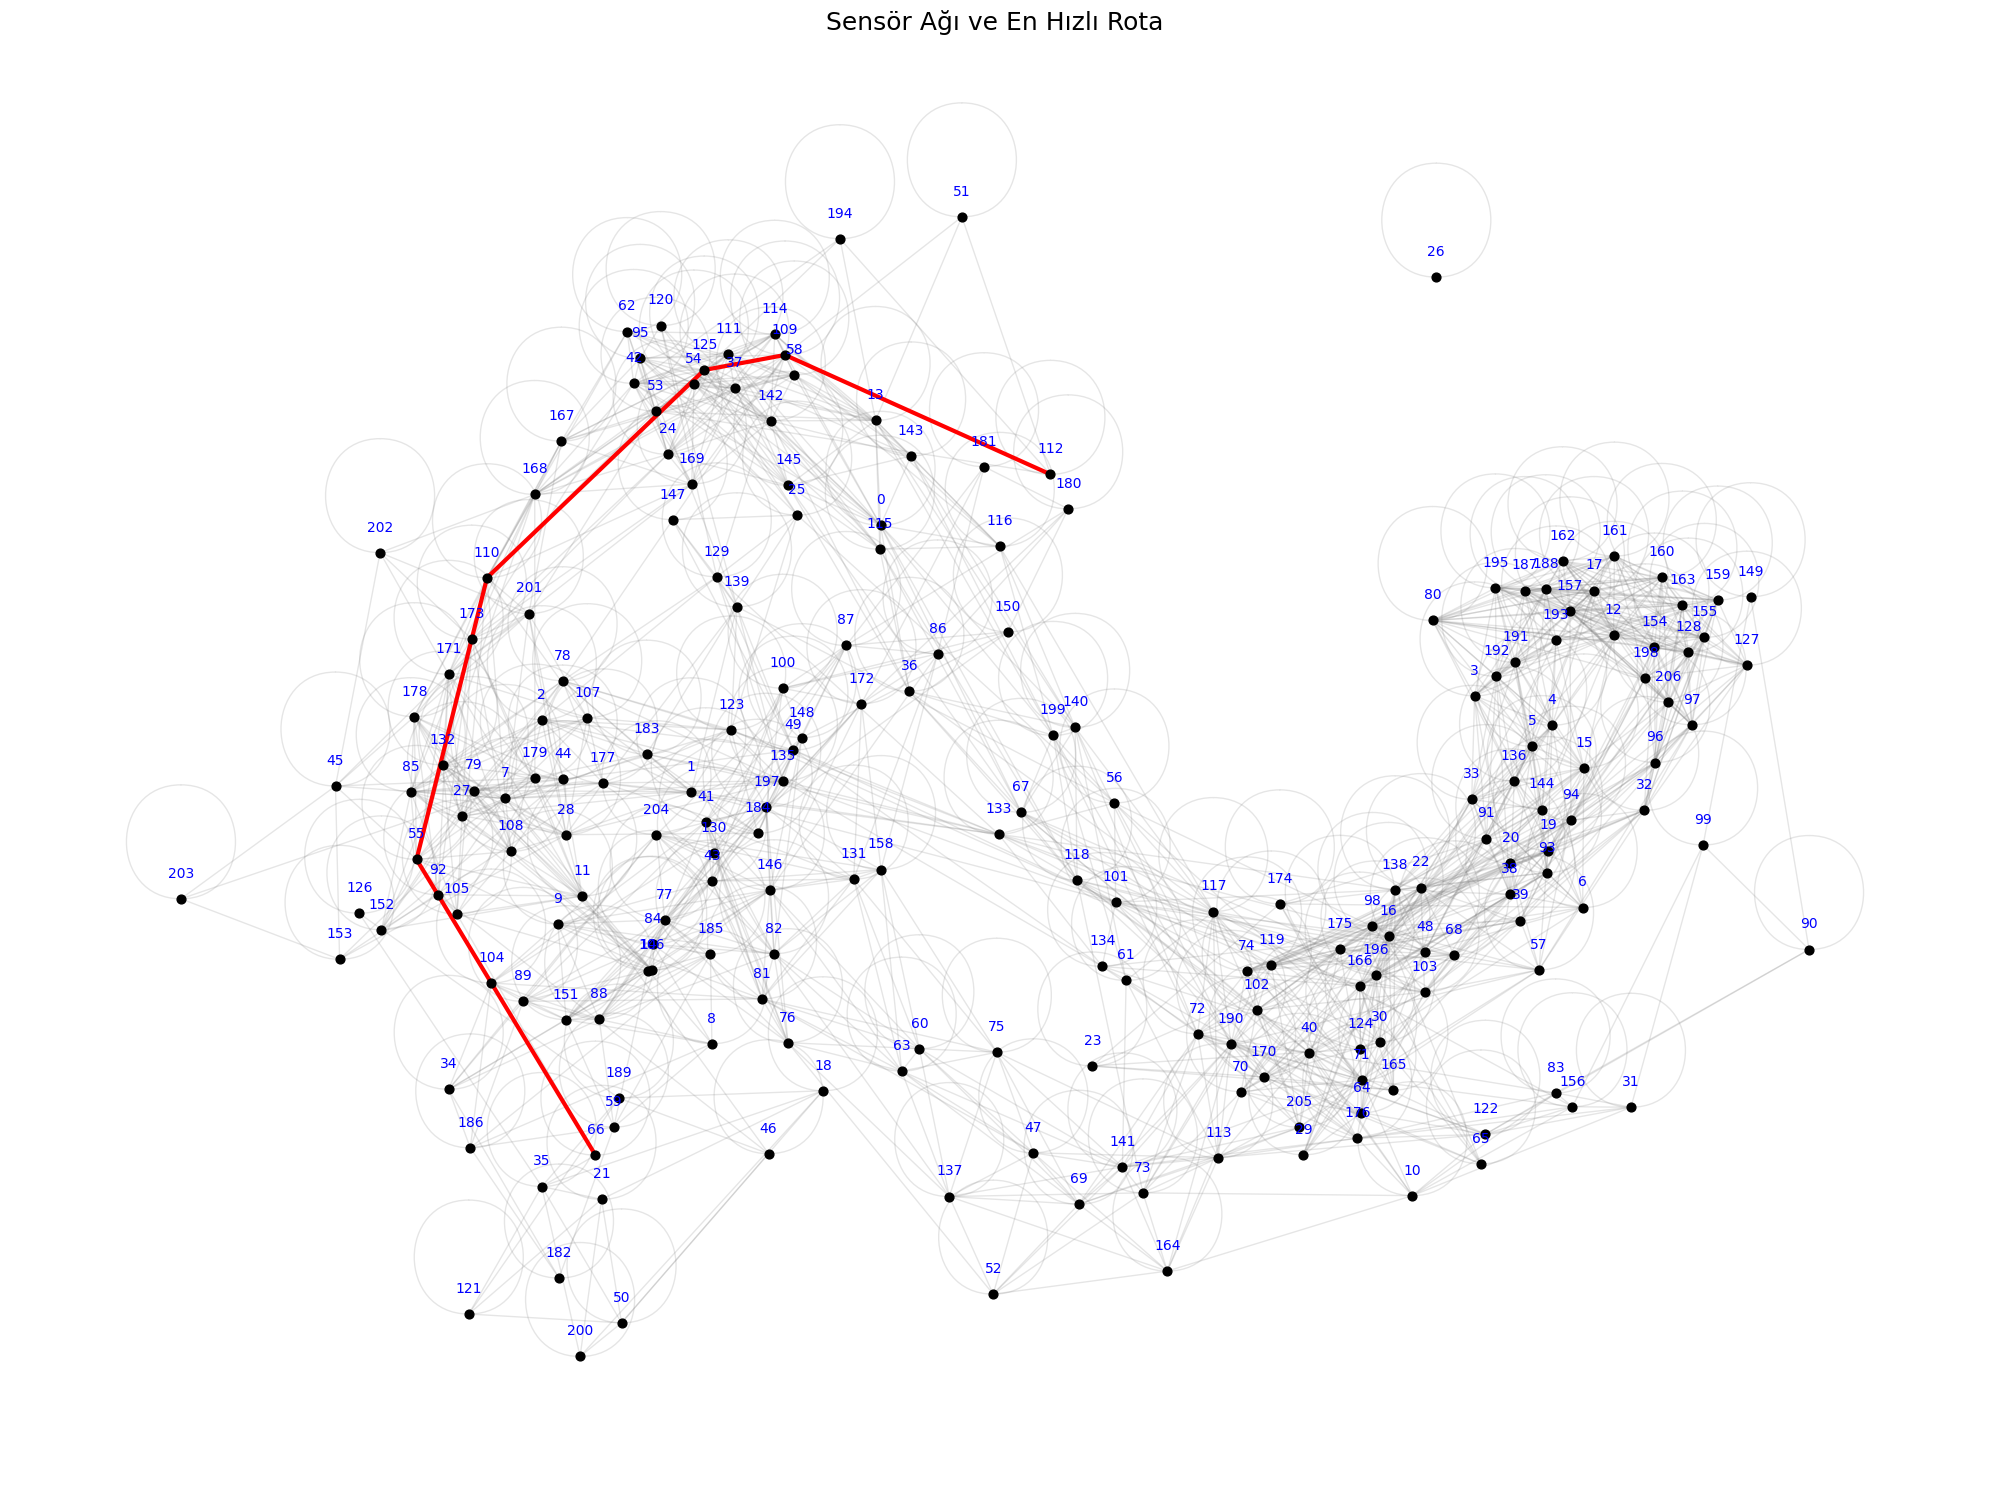

In [ ]:
import pickle
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# --- Cihaz ayarı ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Adj matrisi yükle ---
with open("/content/adj_mx.pkl", 'rb') as f:
    _, _, adj_mx = pickle.load(f, encoding='latin1')

NUM_NODES = adj_mx.shape[0]

# --- Model mimarisini kendi eğittiğin modeline göre tanımla ---
# Örnek: class STGCN(torch.nn.Module): ...
# Burada model tanımı olmalı
# model = STGCN(NUM_NODES, in_channels=1, out_channels=64, pred_len=12)
# model.load_state_dict(torch.load('/content/best_stgcn_model.pth', map_location=device))
# model.to(device)
# model.eval()

# --- Scaler (kendine göre ayarla) ---
class StandardScaler:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def inverse_transform(self, data):
        return data * self.std + self.mean

# scaler = StandardScaler(mean, std)  # Senin scaler'ın

# --- Test verilerini yükle veya hazırla ---
# X_test, y_test numpy array olarak olmalı (örnek: (num_samples, seq_len, num_nodes))
# Burada X_test_tensor gibi modeli besleyecek tensöre çevir
# X_test_tensor = torch.from_numpy(X_test).float().permute(0,2,1).unsqueeze(1).to(device)
# y_test_tensor = ...

# --- Model ile tahmin yap ---
# with torch.no_grad():
#     output = model(X_test_tensor, torch.tensor(adj_mx, dtype=torch.float32).to(device))
# output shape: (batch_size, num_nodes, pred_len)

# --- Tahmin ve ağırlık hesaplama ---
# sample_idx = 0  # Kullanmak istediğin test örneği
# time_step_idx = 0  # Öngörü zamanı
# predicted_speeds = scaler.inverse_transform(output[sample_idx, :, time_step_idx].cpu().numpy())

# --- Base lengths (kenar uzunluğu veya 1 olarak sabit) ---
base_lengths = np.where(adj_mx > 0, 1.0, 0.0)

# --- NetworkX graf oluştur ---
G = nx.Graph()
for i in range(NUM_NODES):
    for j in range(NUM_NODES):
        if adj_mx[i, j] > 0:
            G.add_edge(i, j, weight=base_lengths[i, j])

def compute_edge_weights(predicted_speeds, base_lengths):
    epsilon = 1e-3
    weights = np.zeros_like(base_lengths)
    for i in range(NUM_NODES):
        for j in range(NUM_NODES):
            if base_lengths[i, j] > 0:
                avg_speed = max((predicted_speeds[i] + predicted_speeds[j]) / 2, epsilon)
                weights[i, j] = base_lengths[i, j] / avg_speed
    return weights

def update_graph_weights(G, weights):
    for i, j in G.edges():
        G[i][j]['weight'] = weights[i, j]

def find_fastest_route(G, source_node, target_node):
    try:
        path = nx.dijkstra_path(G, source=source_node, target=target_node, weight='weight')
        return path
    except nx.NetworkXNoPath:
        print(f"{source_node} ile {target_node} arasında rota bulunamadı.")
        return None

# Pozisyonları genişletilmiş k parametresi ile hesapla
pos = nx.spring_layout(G, seed=42, k=5.0 / np.sqrt(NUM_NODES))  # k artırıldı, default yaklaşık 0.1 civarıdır

def plot_graph_and_route(G, pos, route):
    plt.figure(figsize=(20, 15))  # Daha büyük görsel boyutu

    nx.draw_networkx_nodes(G, pos, node_size=40, node_color='black', node_shape='o')
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='grey')

    if route is not None and len(route) > 1:
        path_edges = list(zip(route[:-1], route[1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3)

    labels = {node: str(node) for node in G.nodes()}
    label_pos = {k: (v[0], v[1] + 0.04) for k, v in pos.items()}  # Yazıları biraz daha yukarı kaydırdık
    nx.draw_networkx_labels(G, label_pos, labels, font_size=10, font_color='blue')

    plt.title("Sensör Ağı ve En Hızlı Rota", fontsize=18)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# --- Kullanıcıdan başlangıç ve hedef seç ---
while True:
    try:
        source_node = int(input(f"Başlangıç sensör ID'si girin (0-{NUM_NODES-1}): "))
        target_node = int(input(f"Hedef sensör ID'si girin (0-{NUM_NODES-1}): "))
        if 0 <= source_node < NUM_NODES and 0 <= target_node < NUM_NODES:
            break
        else:
            print("Geçerli sensör ID girin.")
    except ValueError:
        print("Tam sayı girin.")

# --- Burada kendi tahmin hızlarını kullan ---
# Örnek (düz 1 ile): predicted_speeds = np.ones(NUM_NODES)
# Sen model çıktılarını burada kullanmalısın:
predicted_speeds = np.ones(NUM_NODES)  # Burası örnek, senin model çıkışı

# Ağırlıkları güncelle ve rota bul
weights = compute_edge_weights(predicted_speeds, base_lengths)
update_graph_weights(G, weights)
route = find_fastest_route(G, source_node, target_node)

print(f"En hızlı rota ({source_node} → {target_node}): {route}")

# --- Grafik çiz ---
plot_graph_and_route(G, pos, route)
